# Анализ данных задачи МКБ

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import time

%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


In [19]:
%config Completer.use_jedi = False

# чтобы много строк было видно
# pd.options.display.max_rows = 300

In [20]:
import lightgbm as lgb

# обучение
data_train = pd.read_csv('train_dataset_hackathon_mkb.csv', encoding='cp1251', delimiter=';')
# контроль
data_test = pd.read_csv('test_dataset_hackathon_mkb.csv', encoding='cp1251', delimiter=';')

print (data_train.shape, data_test.shape)

(17891, 124) (7330, 123)


# Смотрим на данные

Например, сразу смущает "1 января" - проверить, особая ли это дата

In [4]:
data_train.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,1.083075e+09,656055000.0,8.834700e+07,NaN,106919000.0,293404000.0,1.122418e+09,1.479338e+09,3.908700e+07,-19204000.0,1.031700e+09,9.179060e+09,NaN,2.112180e+09,7.426504e+09,4.955724e+10,4.648680e+10,5.565080e+08,1.424790e+09,1.089145e+09,2.401140e+08,137626000.0,310096000.0,7.625800e+07,1.0,10AUG1993:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,01JUL2006:00:00:00,01JAN1960:00:00:00,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,NaN,6746000.0,1.190000e+06,NaN,50000.0,NaN,6.500000e+04,1.494000e+06,6.550000e+05,NaN,7.067400e+07,1.825700e+07,NaN,NaN,3.764000e+06,5.134000e+07,4.299900e+07,3.249000e+06,NaN,5.092000e+06,1.265000e+06,NaN,NaN,6.800000e+05,1.0,04FEB1992:00:00:00,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,30AUG2002:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.

In [23]:
data_train.sample(5)

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
9886,9887,3173,14SEP2018:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4139000.0,NaN,NaN,4137000.0,NaN,2000.0,NaN,3602000.0,10000.0,NaN,NaN,NaN,3592000.0,NaN,NaN,NaN,NaN,537000.0,NaN,537000.0,NaN,NaN,4139000.0,4139000.0,-221000.0,3216000.0,3437000.0,-221000.0,NaN,NaN,-419000.0,NaN,NaN,NaN,NaN,198000.0,-419000.0,NaN,NaN,3914000.0,NaN,NaN,28000.0,4453000.0,4103000.0,350000.0,NaN,NaN,270000.0,NaN,8000.0,219000.0,1.0,29DEC2010:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,12.0,40.0,1.270100e+10,40.0,0 .. 5,29DEC2010:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,33.14,0.0,0.0,1.0,220651.0,0.0,4.0,466289.0,4.0,267477.0,0.0,4.0,0.0,2.0,2.0,503960.0,17.0,4.0,9.0,7.0,1052091.0,92.0,2.0,23.0,22.0,5896127.0,352.0,9.0,128.0,123.0,15011403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5505,5506,8676,23MAY2018:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67000.0,12000.0,NaN,53000.0,NaN,2000.0,NaN,28000.0,10000.0,NaN,NaN,NaN,18000.0,NaN,NaN,NaN,NaN,39000.0,NaN,39000.0,NaN,NaN,67000.0,67000.0,64000.0,187000.0,123000.0,31000.0,33000.0,NaN,23000.0,NaN,NaN,NaN,NaN,8000.0,18000.0,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10JUL2017:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,65.0,34.0,6.570100e+10,34.0,0 .. 5,10JUL2017:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,46.69.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,187000.0,1.0,0.0,1.0,1.0,187000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13075,13076,7877,14DEC2018:00:00:00,0,0,127000.0,NaN,127000.0,NaN,NaN,NaN,NaN,14175000.0,157000.0,NaN,12564000.0,NaN,1453000.0,NaN,98000.0,10000.0,NaN,88000.0,NaN,NaN,NaN,NaN,NaN,NaN,14204000.0,NaN,14204000.0,NaN,NaN,14302000.0,14302000.0,309000.0,10253000.0,9944000.0,72000.0,NaN,237000.0,NaN,NaN,NaN,NaN,NaN,72000.0,NaN,NaN,127000.0,7809000.0,NaN,NaN,9722000.0,4331000.0,3984000.0,44000.0,NaN,303000.0,NaN,NaN,NaN,NaN,1.0,03SEP1997:00:00:00,Частная собственность,Некоммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,36.0,33.0,3.674000e+10,33.0,16 .. 50,05MAR2003:00:00:00,01JAN1960:00:00:00,0.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,85.42.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
data_test.head()

,id_contract,id_client,SIGN_DATE,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,17892,3620,08APR2019:00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17893,4101,08APR2019:00:00:00,0,1906000.0,NaN,1906000.0,NaN,NaN,NaN,NaN,14838000.0,4392000.0,NaN,727000.0,NaN,9719000.0,NaN,15222000.0,150000.0,NaN,NaN,NaN,15072000.0,NaN,NaN,NaN,NaN,1522000.0,NaN,1522000.0,NaN,NaN,16744000.0,16744000.0,2998000.0,310151000.0,307153000.0,2998000.0,NaN,NaN,2998000.0,NaN,NaN,NaN,NaN,NaN,2398000.0,600000.0,2722000.0,2039000.0,NaN,NaN,15201000.0,326903000.0,322811000.0,4092000.0,NaN,NaN,4092000.0,NaN,NaN,3274000.0,1.0,02MAR2010:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,24.0,30.0,2.460747e+10,30.0,16 .. 50,02MAR2010:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,5.0,2.0,2.0,2.0,46.3,2.0,0.0,0.0,0.0,0.0,7.0,4726558.0,0.0,0.0,0.0,181.0,0.0,77.0,47.0,17883526.0,1182.0,14.0,589.0,533.0,169299901.0,1204.0,2.0,857.0,767.0,138194657.0,10240.0,69.0,7439.0,7100.0,1.187411e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17894,9589,08APR2019:00:00:00,0,147000.0,NaN,147000.0,NaN,NaN,NaN,NaN,95529000.0,29812000.0,7000.0,56538000.0,504000.0,8430000.0,238000.0,4145000.0,2538000.0,NaN,NaN,NaN,1607000.0,NaN,NaN,NaN,NaN,91531000.0,NaN,91531000.0,NaN,NaN,95676000.0,95676000.0,48975000.0,506023000.0,457048000.0,1753000.0,47222000.0,NaN,1771000.0,NaN,NaN,NaN,726000.0,708000.0,1400000.0,371000.0,1099000.0,122709000.0,NaN,NaN,166904000.0,150036000.0,117059000.0,1287000.0,31690000.0,NaN,1022000.0,NaN,NaN,717000.0,1.0,12OCT1998:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,75.0,34.0,7.570139e+10,34.0,16 .. 50,29DEC2002:00:00:00,01JAN1960:00:00:00,0.0,1.0,2.0,0.0,2.0,0.0,3.0,1.0,1.0,1.0,33.12,10.0,2272145.0,2.0,176875.0,0.0,103.0,27542049.0,14.0,1743130.0,2.0,31.0,2.0,14.0,11.0,3681170.0,177.0,24.0,73.0,63.0,46085424.0,36.0,10.0,7.0,7.0,2375210.0,764.0,50.0,362.0,344.0,9.836260e+07,NaN,1.0,3.0,NaN,NaN,NaN,NaN
3,17895,11546,08APR2019:00:00:00,0,NaN,NaN,NaN

## чем отличаются обучение и тест

Локальное тестирование должно быть устроено также как и глобальное

In [111]:
A1 = set(data_train.id_client.values)
A2 = set(data_test.id_client.values)
print (len(A1-A2), len(A1&A2), len(A2-A1))

7974 948 3813


## целевой признак

In [6]:
data_train.TARGET.value_counts()

0    10502
1     7389
Name: TARGET, dtype: int64

In [24]:
data_train.TARGET.mean()

0.4130009501984238

In [7]:
pd.crosstab(data_train.IP_flag, data_train.TARGET)

TARGET,0,1
IP_flag,,
0,8214,6177
1,2288,1212


In [112]:
data_train.IP_flag.mean(), data_test.IP_flag.mean()

(0.1956290872505729, 0.2432469304229195)

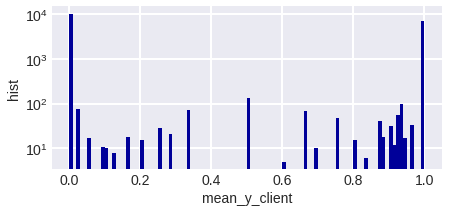

In [25]:
data_train['mean_y_client'] = data_train.id_client.map(data_train.groupby('id_client')['TARGET'].mean())

plt.figure(figsize=(7, 3))
plt.hist(data_train['mean_y_client'], bins=100, color='#000099');
plt.xlabel('mean_y_client')
plt.ylabel('hist')
plt.yscale('log')
plt.grid(lw=2)

Но тут крайние столбцы могут соответствовать клиентам с одной записью...

(-5.0, 9000.0)

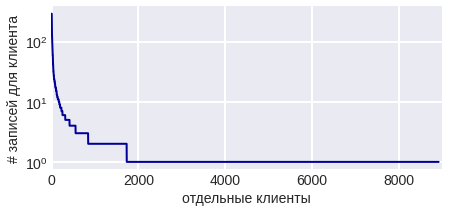

In [25]:
tmp = data_train.id_client.value_counts().values
#plt.bar(np.arange(len(tmp)), tmp)
plt.figure(figsize=(7, 3))
plt.plot(np.arange(len(tmp)), tmp, c='#000099', lw=2)
plt.grid(lw=2)
plt.yscale('log')
plt.xlabel('отдельные клиенты')
plt.ylabel('# записей для клиента')
plt.xlim([-5, 9000])

#plt.hist(data_train['mean_y_client'], bins=100, color='#000099');
#
#plt.ylabel('hist')


надо посмотреть на клиентов с непостоянным таргетом:

In [27]:
data_train[(data_train.mean_y_client.abs() < 0.99) & (data_train.mean_y_client.abs() > 0.01)].id_client.value_counts()[:10]

10714    75
5156     66
2582     55
2405     33
10868    21
3873     17
11764    17
2053     16
7859     16
5687     15
Name: id_client, dtype: int64

In [28]:
data_train[data_train.id_client == 8683]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
16900,16901,8683,11MAR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1672000.0,28000.0,NaN,5000.0,NaN,1639000.0,NaN,545000.0,10000.0,NaN,NaN,NaN,535000.0,NaN,NaN,NaN,NaN,1127000.0,NaN,1127000.0,NaN,NaN,1672000.0,1672000.0,1268000.0,4142000.0,2874000.0,1268000.0,NaN,NaN,669000.0,NaN,NaN,NaN,NaN,599000.0,535000.0,134000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18SEP2018:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,65.0,34.0,6.570100e+10,34.0,0 .. 5,18SEP2018:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,46.69.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.888889
16978,16979,8683,12MAR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1672000.0,28000.0,NaN,5000.0,NaN,1639000.0,NaN,545000.0,10000.0,NaN,NaN,NaN,535000.0,NaN,NaN,NaN,NaN,1127000.0,NaN,1127000.0,NaN,NaN,1672000.0,1672000.0,1268000.0,4142000.0,2874000.0,1268000.0,NaN,NaN,669000.0,NaN,NaN,NaN,NaN,599000.0,535000.0,134000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18SEP2018:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,65.0,34.0,6.570100e+10,34.0,0 .. 5,18SEP2018:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,46.69.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.888889
17145,17146,8683,19MAR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1672000.0,28000.0,NaN,5000.0,NaN,1639000.0,NaN,545000.0,10000.0,NaN,NaN,NaN,535000.0,NaN,NaN,NaN,NaN,1127000.0,NaN,1127000.0,NaN,NaN,1672000.0,1672000.0,1268000.0,4142000.0,2874000.0,1268000.0,NaN,NaN,669000.0,NaN,NaN,NaN,NaN,599000.0,535000.0,134000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18SEP2018:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,65.0,34.0,6.570100e+10,34.0,0 .. 5,18SEP2018:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,46.69.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.888889
17226,17227,8683,20MAR2019:00:00:00,0,1,NaN,NaN,NaN,Na

Подписывание договоров в соседние дни - оказалось, что это важный признак:

* что было в соседние дни
* что было в этот день
* =/= у данного клеинта
* =/= в данном регионе

посмотрите на неизменность финансовых F-показателей

это даёт возможность сматчить клиентов, если их разделили

## отдельные клиенты

In [32]:
data_train[data_train.id_client == 10868]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
190,191,10868,09JAN2018:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256928000.0,NaN,NaN,166971000.0,70428000.0,19529000.0,NaN,244553000.0,10000.0,NaN,NaN,NaN,244543000.0,NaN,NaN,NaN,NaN,12375000.0,NaN,12375000.0,NaN,NaN,256928000.0,256928000.0,102285000.0,102928000.0,643000.0,100311000.0,1158000.0,816000.0,103234000.0,NaN,374000.0,NaN,4204000.0,1655000.0,98497000.0,NaN,NaN,122723000.0,NaN,NaN,9532000.0,60624000.0,NaN,58568000.0,1606000.0,450000.0,60067000.0,45000.0,NaN,56104000.0,1.0,11JUN2009:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,45.0,30.0,4.592500e+10,30.0,0 .. 5,11JUN2009:00:00:00,01JAN1960:00:00:00,0.0,1.0,5.0,0.0,0.0,0.0,4.0,7.0,2.0,2.0,18.13,23.0,8918889.0,0.0,0.0,1.0,62.0,19187840.0,5.0,312650.0,4.0,943.0,123.0,550.0,480.0,582584717.0,2082.0,486.0,1101.0,831.0,9.636683e+08,6711.0,64.0,3146.0,2484.0,406062323.0,26702.0,511.0,13925.0,13037.0,2.303416e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714
1280,1281,10868,30JAN2018:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256928000.0,NaN,NaN,166971000.0,70428000.0,19529000.0,NaN,244553000.0,10000.0,NaN,NaN,NaN,244543000.0,NaN,NaN,NaN,NaN,12375000.0,NaN,12375000.0,NaN,NaN,256928000.0,256928000.0,102285000.0,102928000.0,643000.0,100311000.0,1158000.0,816000.0,103234000.0,NaN,374000.0,NaN,4204000.0,1655000.0,98497000.0,NaN,NaN,122723000.0,NaN,NaN,9532000.0,60624000.0,NaN,58568000.0,1606000.0,450000.0,60067000.0,45000.0,NaN,56104000.0,1.0,11JUN2009:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,45.0,30.0,4.592500e+10,30.0,0 .. 5,11JUN2009:00:00:00,01JAN1960:00:00:00,0.0,1.0,5.0,0.0,0.0,0.0,4.0,7.0,2.0,2.0,18.13,23.0,8918889.0,0.0,0.0,1.0,62.0,19187840.0,5.0,312650.0,4.0,943.0,123.0,550.0,480.0,582584717.0,2082.0,486.0,1101.0,831.0,9.636683e+08,6711.0,64.0,3146.0,2484.0,406062323.0,26702.0,511.0,13925.0,13037.0,2.303416e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714
2287,2288,10868,26FEB2018:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256928000.0,NaN,NaN,166971000.0,70428000.0,19529000.0,NaN,244553000.0,10000.0,NaN,NaN,NaN,244543000.0,NaN,NaN,NaN,NaN,12375000.0,NaN,12375000.0,NaN,NaN,256928000.0,256928000.0,102285000.0,102928000.0,643000.0,100311000.0,1158000.0,816000.0,103234000.0,NaN,374000.0,NaN,4204000.0,1655000.0,98497000.0,NaN,NaN,122723000.0,NaN,NaN,9532000.0,60624000.0,NaN,58568000.0,1606000.0,45

In [33]:
data_train[data_train.id_client == 4194]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
907,908,4194,23JAN2018:00:00:00,0,0,4192000.0,NaN,4192000.0,NaN,NaN,NaN,NaN,5.041950e+08,102810000.0,7919000.0,163097000.0,NaN,229907000.0,461000.0,63829000.0,10000.0,NaN,6189000.0,NaN,57630000.0,30812000.0,30790000.0,22000.0,NaN,4.137460e+08,NaN,4.137460e+08,NaN,NaN,5.083870e+08,5.083870e+08,59562000.0,1.093811e+09,1.034249e+09,-72298000.0,130237000.0,1623000.0,31960000.0,NaN,802000.0,19000.0,127441000.0,23966000.0,25020000.0,6918000.0,119000.0,499736000.0,NaN,NaN,477859000.0,1.866379e+09,1.800374e+09,54017000.0,11988000.0,NaN,53779000.0,10000.0,4806000.0,42688000.0,1.0,19SEP2012:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,25.0,41.0,2.570100e+10,41.0,16 .. 50,19SEP2012:00:00:00,01JAN1960:00:00:00,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,46.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667
1269,1270,4194,30JAN2018:00:00:00,0,0,4192000.0,NaN,4192000.0,NaN,NaN,NaN,NaN,5.041950e+08,102810000.0,7919000.0,163097000.0,NaN,229907000.0,461000.0,63829000.0,10000.0,NaN,6189000.0,NaN,57630000.0,30812000.0,30790000.0,22000.0,NaN,4.137460e+08,NaN,4.137460e+08,NaN,NaN,5.083870e+08,5.083870e+08,59562000.0,1.093811e+09,1.034249e+09,-72298000.0,130237000.0,1623000.0,31960000.0,NaN,802000.0,19000.0,127441000.0,23966000.0,25020000.0,6918000.0,119000.0,499736000.0,NaN,NaN,477859000.0,1.866379e+09,1.800374e+09,54017000.0,11988000.0,NaN,53779000.0,10000.0,4806000.0,42688000.0,1.0,19SEP2012:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,25.0,41.0,2.570100e+10,41.0,16 .. 50,19SEP2012:00:00:00,01JAN1960:00:00:00,0.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,46.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667
10080,10081,4194,20SEP2018:00:00:00,0,1,4192000.0,NaN,4192000.0,NaN,NaN,NaN,NaN,5.041950e+08,102810000.0,7919000.0,163097000.0,NaN,229907000.0,461000.0,63829000.0,10000.0,NaN,6189000.0,NaN,57630000.0,30812000.0,30790000.0,22000.0,NaN,4.137460e+08,NaN,4.137460e+08,NaN,NaN,5.083870e+08,5.083870e+08,59562000.0,1.093811e+09,1.034249e+09,-72298000.0,130237000.0,1623000.0,31960000.0,NaN,802000.0,19000.0,127441000.0,23966000.0,25020000.0,6918000.0,11

In [34]:
data_train[data_train.id_client == 6903]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
9741,9742,6903,10SEP2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10APR2014:00:00:00,NaN,NaN,NaN,54.0,30.0,5.462442e+10,30.0,NaN,10APR2014:00:00:00,10APR2014:00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.46,9.0,1046529.0,0.0,0.0,1.0,12.0,1260053.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28APR1986:00:00:00,32.0,мужской,Российская Федерация,0.666667
15983,15984,6903,05FEB2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10APR2014:00:00:00,NaN,NaN,NaN,54.0,30.0,5.462442e+10,30.0,NaN,10APR2014:00:00:00,10APR2014:00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.46,4.0,927156.0,3.0,96657.0,1.0,16.0,2187209.0,4.0,96657.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28APR1986:00:00:00,33.0,мужской,Российская Федерация,0.666667
16115,16116,6903,07FEB2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10APR2014:00:00:00,NaN,NaN,NaN,54.0,30.0,5.462442e+10,30.0,NaN,10APR2014:00:00:00,10APR2014:00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.46,4.0,927156.0,3.0,96657.0,1.0,16.0,2187209.0,4.0,96657.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28APR1986:00:00:00,33.0,мужской,Российская Федерация,0.666667
16318,16319,6903,13FEB2019:00:00:00,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10APR2014:00:00:00,NaN,NaN,NaN,54.0,30.0,5.462442e+10,30.0,NaN,10APR2014:00:00:00,10APR2014:00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.46,4.0,927156.0,3.0,96657.0,1.0,16.0,2187209.0,4.0,96657.0,2.0,NaN,NaN,NaN,NaN,NaN,

## признаки

In [8]:
print (data_train.columns.to_list())

['id_contract', 'id_client', 'SIGN_DATE', 'IP_flag', 'TARGET', 'F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190', 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260', 'F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370', 'F1400', 'F1410', 'F1420', 'F1450', 'F1500', 'F1510', 'F1520', 'F1530', 'F1550', 'F1600', 'F1700', 'F2100', 'F2110', 'F2120', 'F2200', 'F2210', 'F2220', 'F2300', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350', 'F2400', 'F2410', 'F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1', 'F2110_LAG1', 'F2120_LAG1', 'F2200_LAG1', 'F2210_LAG1', 'F2220_LAG1', 'F2300_LAG1', 'F2320_LAG1', 'F2330_LAG1', 'F2400_LAG1', 'EGRPOINCLUDED', 'DATEFIRSTREG', 'OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'OKTMO_FED', 'WORKERSRANGE', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'COUNTCOOWNERFCSM', 'COUNTCOOWNERROSSTAT', 'COUNTCOOWNEREGRUL', 'COUNTBRANCH', 'COUNTBRANCHROSSTAT', 'COUNTBRANCHEGRUL', 'TELEPHONECOUNT', 'MANA

In [9]:
# проверили, что оканчиваются на 00:00:00
columns_date = [name for name in data_train.columns if 'DATE' in name]
for name in columns_date:
    print (name, data_train[name].str[-8:].unique(), data_test[name].str[-8:].unique())

SIGN_DATE ['00:00:00'] ['00:00:00']
DATEFIRSTREG ['00:00:00' nan] [nan '00:00:00']
TAXREG_REGDATE ['00:00:00' nan] [nan '00:00:00']
TAXREGPAY_REGDATE ['00:00:00' nan] [nan '00:00:00']
BIRTHDATE [nan '00:00:00'] [nan '00:00:00']


In [114]:
lst =[]
for name in data_train.columns:
    nu = len(data_train[name].unique())
    nisnan = data_train[name].isnull().sum()
    lst.append([name, nu, nisnan, data_train[name].unique()[:min(nu, 10)]])
    
pd.DataFrame(lst, columns=['column', 'nunique', 'nnull', 'values'])

,column,nunique,nnull,values
0,id_contract,17891,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
1,id_client,8922,0,"[1847, 4650, 4770, 12237, 9988, 10099, 10714, ..."
2,SIGN_DATE,439,0,"[2018-01-01T00:00:00.000000000, 2018-01-02T00:..."
3,IP_flag,2,0,"[0, 1]"
4,TARGET,2,0,"[0, 1]"
...,...,...,...,...
128,year,2,0,"[2018, 2019]"
129,month,12,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
130,week,52,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
131,tik,16,0,"[24216, 24217, 24218, 24219, 24220, 24221, 242..."


## F-признаки

In [38]:
#data_train[data_train.FLAG_DISQUALIFICATION > 0]
columns_F = [name for name in data_train.columns if (name[0]=='F')&(name[1]!='L')]
print (columns_F)

['F1100', 'F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190', 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260', 'F1300', 'F1310', 'F1320', 'F1350', 'F1360', 'F1370', 'F1400', 'F1410', 'F1420', 'F1450', 'F1500', 'F1510', 'F1520', 'F1530', 'F1550', 'F1600', 'F1700', 'F2100', 'F2110', 'F2120', 'F2200', 'F2210', 'F2220', 'F2300', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350', 'F2400', 'F2410', 'F1150_LAG1', 'F1230_LAG1', 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1', 'F2110_LAG1', 'F2120_LAG1', 'F2200_LAG1', 'F2210_LAG1', 'F2220_LAG1', 'F2300_LAG1', 'F2320_LAG1', 'F2330_LAG1', 'F2400_LAG1']


In [36]:
lst = []
for name in columns_F:
    lst.append([name,
                data_train[name].isnull().mean(),
                data_test[name].isnull().mean(),
                (data_train[name] < 0).sum(),
                (data_test[name] < 0).sum(),
                (data_train[name] == 0).sum(),
                (data_test[name] == 0).sum()
               ])
    
pd.DataFrame(lst, columns=['column', 'train_null', 'test_null', 'train<0', 'test<0', 'train=0', 'test=0'])    

,column,train_null,test_null,train<0,test<0,train=0,test=0
0,F1100,0.612319,0.660300,1,0,0,0
1,F1110,0.920630,0.937517,0,0,0,0
2,F1150,0.645576,0.683356,0,0,0,0
3,F1160,0.980661,0.989222,1,0,0,0
4,F1170,0.916215,0.933697,0,0,0,0
5,F1180,0.860265,0.907367,14,7,0,0
6,F1190,0.915041,0.937517,0,0,0,0
7,F1200,0.337656,0.373670,1,1,0,0
8,F1210,0.455872,0.481992,5,0,0,0
9,F1220,0.815662,0.845975,6,0,0,0


используем исключительно эти F-признаки

кстати, полученную линейную комбинацию можно использовать как отдельный признак

тонкость: пропущенные значения надо хитрее заполнять (например, предыдущими известными) - это видно по данным

In [39]:
i1 = (pd.to_datetime(data_train['SIGN_DATE'], format='%d%b%Y:%X') < pd.to_datetime('01-01-2019')) 
i2 = (pd.to_datetime(data_train['SIGN_DATE'], format='%d%b%Y:%X') >= pd.to_datetime('01-01-2019'))

X1 = data_train.loc[i1, columns_F]
X2 = data_train.loc[i2, columns_F]
y1 = data_train.TARGET[i1].values
y2 = data_train.TARGET[i2].values

print (X1.shape, y1.shape, X2.shape, y2.shape)

X1 = X1.fillna(0.0).values
X1 = np.sign(X1) * np.log1p(np.abs(X1))

X2 = X2.fillna(0.0).values
X2 = np.sign(X2) * np.log1p(np.abs(X2))

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X1, y1)

a1 = model.predict_proba(X1)[:,1] # .fillna(0.0)
a2 = model.predict_proba(X2)[:,1] # .fillna(0.0)

from sklearn.metrics import roc_auc_score
roc_auc_score(y1, a1), roc_auc_score(y2, a2)

# c преобразованиями (0.7382910723740026, 0.726250517977071)
# без преобразований (0.6580209376534902, 0.6874160673517822)

(14331, 59) (14331,) (3560, 59) (3560,)


(0.7382910723740026, 0.726250517977071)

In [40]:
from sklearn.metrics import log_loss

log_loss(y1, a1), log_loss(y2, a2)

(0.5726115573695905, 0.566300842050589)

Text(0, 0.5, 'hist')

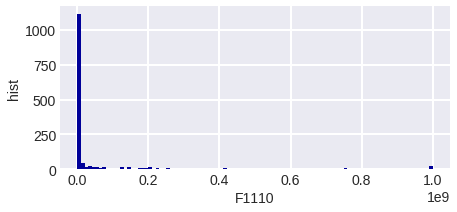

In [57]:
f = data_train['F1110'].clip(lower=0, upper=1e09).values

plt.figure(figsize=(7, 3))
plt.hist(f,bins=100, color='#000099');
plt.grid(lw=2)
plt.xlabel('F1110')
plt.ylabel('hist')

Text(0, 0.5, 'hist')

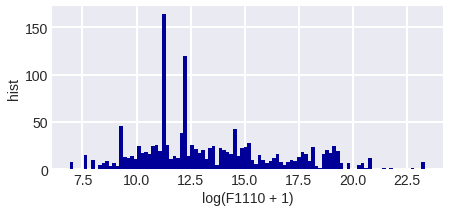

In [59]:
f = data_train['F1110'].values

plt.figure(figsize=(7, 3))
plt.hist(np.log1p(f),bins=100, color='#000099');
plt.grid(lw=2)
plt.xlabel('log(F1110 + 1)')
plt.ylabel('hist')

In [36]:
data_train['F1110'].value_counts()

7.300000e+04    137
2.060000e+05     98
1.000000e+04     40
1.790000e+05     22
2.000000e+03     15
               ... 
7.131800e+07      1
5.780000e+05      1
5.390300e+07      1
1.427400e+07      1
7.793332e+09      1
Name: F1110, Length: 452, dtype: int64

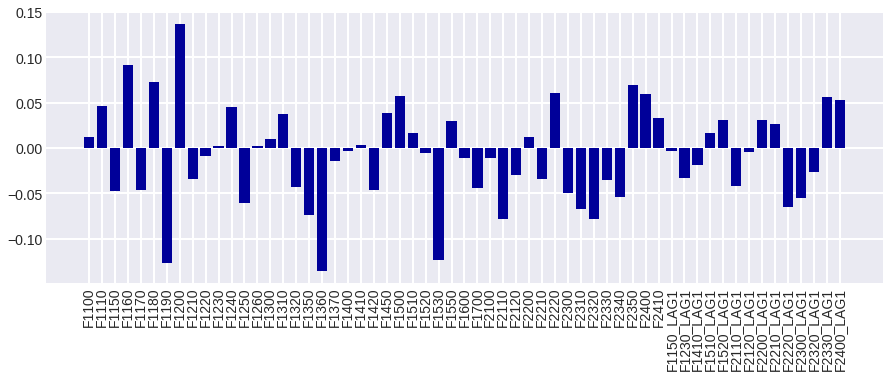

In [122]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(columns_F)), model.coef_[0,:], color='#000099')
plt.xticks(np.arange(len(columns_F)), columns_F, rotation=90);
# np.arange(len(columns_F)).shape, model_lr.coef_.shape
plt.grid(lw=2)

## даты

In [41]:
columns_date = [name for name in data_train.columns if 'DATE' in name]
print (columns_date)
for name in columns_date:
    data_train[name] = pd.to_datetime(data_train[name], format='%d%b%Y:%X')
    data_test[name] = pd.to_datetime(data_test[name], format='%d%b%Y:%X')  

['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'BIRTHDATE']


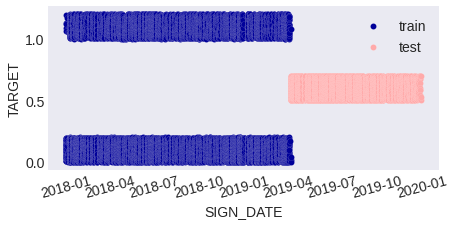

In [65]:
plt.figure(figsize=(7, 3))
plt.scatter(data_train.SIGN_DATE, data_train.TARGET.values + 0.2*np.random.rand(17891), c='#000099', lw=0.1, edgecolor='w', label='train')
plt.scatter(data_test.SIGN_DATE, 0.5 + 0.2*np.random.rand(7330), c='#FFAAAA', lw=0.1, edgecolor='w', label='test')
plt.xlabel('SIGN_DATE')
plt.ylabel('TARGET')
plt.xticks(rotation=15);
#plt.xlim([pd.to_datetime('2017-12-25'), pd.to_datetime('2019-04-16')])
plt.legend();

In [42]:
data_train.head()

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
0,1,1847,2018-01-01,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,1.083075e+09,656055000.0,8.834700e+07,NaN,106919000.0,293404000.0,1.122418e+09,1.479338e+09,3.908700e+07,-19204000.0,1.031700e+09,9.179060e+09,NaN,2.112180e+09,7.426504e+09,4.955724e+10,4.648680e+10,5.565080e+08,1.424790e+09,1.089145e+09,2.401140e+08,137626000.0,310096000.0,7.625800e+07,1.0,1993-08-10,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,2006-07-01,1960-01-01,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1,2,4650,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
2,3,4770,2018-01-01,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,NaN,6746000.0,1.190000e+06,NaN,50000.0,NaN,6.500000e+04,1.494000e+06,6.550000e+05,NaN,7.067400e+07,1.825700e+07,NaN,NaN,3.764000e+06,5.134000e+07,4.299900e+07,3.249000e+06,NaN,5.092000e+06,1.265000e+06,NaN,NaN,6.800000e+05,1.0,1992-02-04,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,2002-08-30,1960-01-01,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,

Тонкость: созданные алгоритмы нельзя будет использовать на практике, т.к. "таргет вчера" неизвестен

Анализ сезонности

полезно посмотреть и на изменение других признаков по времени

Text(0, 0.5, 'mean(TARGET)')

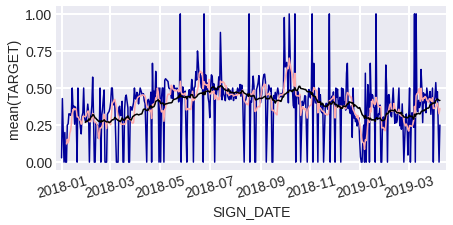

In [74]:
tmp = data_train.groupby('SIGN_DATE')['TARGET'].mean()
plt.figure(figsize=(7, 3))
plt.plot(tmp, c='#000099')
plt.plot(tmp.rolling(window=7).mean(), c='#FFAAAA')
plt.plot(tmp.rolling(window=30).mean(), c='k')
plt.xticks(rotation=15);
plt.grid(lw=2)
plt.xlim([pd.to_datetime('2017-12-25'), pd.to_datetime('2019-04-16')]);
plt.xlabel('SIGN_DATE')
plt.ylabel('mean(TARGET)')

In [93]:
data_train['year'] = data_train.SIGN_DATE.dt.year
data_train['month'] = data_train.SIGN_DATE.dt.month - 1
data_train['week'] = data_train.SIGN_DATE.dt.isocalendar().week - 1
#data_train['tik'] = 52*data_train['year'] + data_train['week']
data_train['tik'] = 12*data_train['year'] + data_train['month']
data_train['c'] = 1

data_test['year'] = data_test.SIGN_DATE.dt.year
data_test['month'] = data_test.SIGN_DATE.dt.month - 1
data_test['week'] = data_test.SIGN_DATE.dt.isocalendar().week - 1
#data_test['tik'] = 52*data_test['year'] + data_test['week']
data_test['tik'] = 12*data_test['year'] + data_test['month']
data_test['c'] = 1

(24215.0, 24240.0)

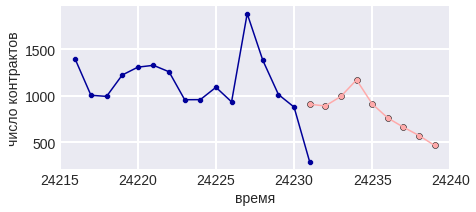

In [108]:
tmp = data_train.groupby('tik')['c'].sum()
tmp2 = data_test.groupby('tik')['c'].sum()

plt.figure(figsize=(7, 3))
plt.plot(tmp, c='#000099')
#plt.plot(tmp.index, tmp, c='#000099', lw=1)
plt.scatter(tmp.index, tmp, c='#000099', edgecolor='w', lw=0.5)
plt.plot(tmp2, c='#FFAAAA')
plt.scatter(tmp2.index, tmp2, c='#FFAAAA', edgecolor='k', lw=0.5)
plt.xlabel('время')
plt.ylabel('число контрактов')
plt.grid(lw=2)
plt.xlim([24215, 24240])

Тест не похож на обучение - при прогнозе это почти всегда так.

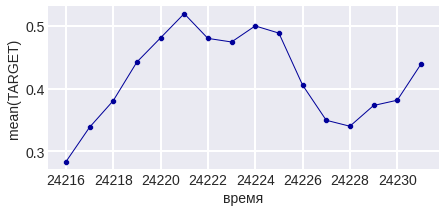

In [109]:
tmp = data_train.groupby('tik')['TARGET'].mean()
plt.figure(figsize=(7, 3))
plt.plot(tmp, c='#000099', lw=1)
plt.scatter(tmp.index, tmp, c='#000099', edgecolor='w', lw=0.5)
plt.xlabel('время') # (месяц по счёту)')
plt.ylabel('mean(TARGET)')
plt.grid(lw=2)

к вопросу - постоянен ли таргет, одинаково ли распределены целевые значения на обучении и тесте?

**хак:** можно посмотреть на распределение ответов надёжной модели (см. logreg дальше) - они известны на обучении и на тесте

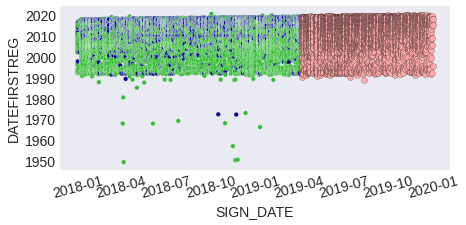

In [73]:
plt.figure(figsize=(7, 3))
plt.scatter(data_train.SIGN_DATE, data_train.DATEFIRSTREG, 20, data_train.TARGET.map({0:'#33BB33', 1:'#000099'}), lw=0.2, edgecolor='w')
plt.scatter(data_test.SIGN_DATE, data_test.DATEFIRSTREG, c='#FFAAAA', lw=0.2, edgecolor='k')

plt.xlabel('SIGN_DATE')
plt.ylabel('DATEFIRSTREG')
plt.xticks(rotation=15);
#plt.yscale('log')
#plt.ylim([pd.to_datetime('2000'), pd.to_datetime('2004')])

In [43]:
data_train.DATEFIRSTREG.value_counts()

2017-08-25    294
2015-10-07    280
2010-02-04    221
2016-05-16    194
2017-08-14    146
             ... 
2009-03-10      1
2017-05-12      1
2006-09-18      1
1996-09-23      1
1995-07-18      1
Name: DATEFIRSTREG, Length: 4227, dtype: int64

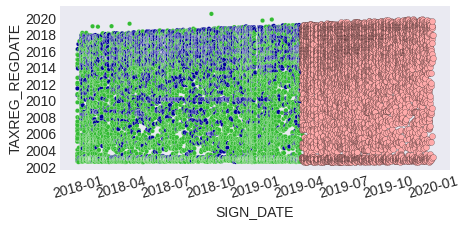

In [76]:
plt.figure(figsize=(7, 3))
plt.scatter(data_train.SIGN_DATE, data_train.TAXREG_REGDATE, 20, data_train.TARGET.map({0:'#33BB33', 1:'#000099'}), lw=0.2, edgecolor='w')
plt.scatter(data_test.SIGN_DATE, data_test.TAXREG_REGDATE, c='#FFAAAA', lw=0.2, edgecolor='k')

plt.xlabel('SIGN_DATE')
plt.ylabel('TAXREG_REGDATE')
plt.xticks(rotation=15);


## дни недели

In [8]:
#data_train['w']= data_train.SIGN_DATE.dt.day_of_week
#print (data_train.groupby('w')['TARGET'].mean())
#print (data_train.groupby('w')['TARGET'].size())
data_train['wd'] = data_train.SIGN_DATE.dt.weekday
data_train['число'] = 1
tmp = pd.concat([data_train.groupby('wd')['TARGET'].mean().round(3), data_train.groupby('wd')['число'].sum()], axis=1)
tmp.index = tmp.index.map({0:'пн', 1:'вт', 2:'ср', 3:'чт', 4:'птн', 5:'сб', 6:'вс'})
tmp

,TARGET,число
wd,,
пн,0.398,5315
вт,0.422,3890
ср,0.406,2958
чт,0.421,2404
птн,0.427,2766
сб,0.387,393
вс,0.515,165


In [16]:
data_train['wd'] = data_train.DATEFIRSTREG.dt.weekday
data_train['число'] = 1
tmp = pd.concat([data_train.groupby('wd')['TARGET'].mean().round(3), data_train.groupby('wd')['число'].sum()], axis=1)
#tmp.index = tmp.index.fillna(-1).astype(int)
tmp.index = tmp.index.map({0:'пн', 1:'вт', 2:'ср', 3:'чт', 4:'птн', 5:'сб', 6:'вс'})
tmp

,TARGET,число
wd,,
пн,0.480,3382
вт,0.400,3242
ср,0.475,3264
чт,0.456,3214
птн,0.385,3110
сб,0.126,167
вс,0.719,178


In [17]:
data_train['wd'] = data_train.BIRTHDATE.dt.weekday
data_train['число'] = 1
tmp = pd.concat([data_train.groupby('wd')['TARGET'].mean().round(3), data_train.groupby('wd')['число'].sum()], axis=1)
tmp.index = tmp.index.map({0:'пн', 1:'вт', 2:'ср', 3:'чт', 4:'птн', 5:'сб', 6:'вс'})
tmp

,TARGET,число
wd,,
пн,0.592,255
вт,0.224,161
ср,0.195,149
чт,0.568,315
птн,0.317,202
сб,0.203,153
вс,0.451,184


Как такое может быть с днями рождения???

И известных дней рождения мало!

id_client можно достаточно точно восстановить по некоторым признакам, например
* DATEFIRSTREG
* BIRTHDATE

но некоторые ошибки всё-таки будут

## IP_client

In [82]:
S = set(data_train[data_train.IP_flag==0].id_client.values) # из-за разбиения на train/test можем не всех учесть
D = data_train[(data_train.IP_flag==1)&(data_train.id_client.isin(S))]
print (D.shape)
D

(630, 128)


,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client,w,wd,C
17,18,10092,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.003413,0,NaN,1
19,20,10092,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.003413,0,NaN,1
29,30,1132,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.000000,0,NaN,1
34,35,822,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.000000,0,NaN,1
40,41,10092,2018-01-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [48]:
f = data_train.groupby('id_client')['IP_flag'].mean()
f[(f > 0.0) & (f < 1.0)].index

Int64Index([  168,   209,   233,   645,   822,   834,   842,   857,  1006,
             1073,  1128,  1132,  1249,  1487,  1535,  1839,  1847,  2700,
             2785,  2789,  2790,  2951,  3226,  3311,  3479,  3586,  3588,
             3629,  3703,  3855,  3916,  4119,  4916,  5614,  5822,  7565,
             7620,  7624,  7775,  7776,  8034,  8436,  8517,  8730,  8801,
             8837,  9194,  9339,  9600,  9996, 10044, 10092, 10097, 10196,
            10197, 10218, 10224, 10342, 10399, 10489, 10552, 10746, 10845,
            11031, 11192, 11209, 11223, 11257, 11374, 11514, 11783, 11922,
            12016, 12018, 12109, 12463],
           dtype='int64', name='id_client')

In [50]:
f = data_train.groupby('id_client')['IP_flag'].mean()
f[f == 1.0].index

Int64Index([    7,     9,    10,    12,    14,    16,    21,    31,    33,
               46,
            ...
            12520, 12526, 12534, 12542, 12545, 12551, 12553, 12562, 12563,
            12570],
           dtype='int64', name='id_client', length=1605)

In [53]:
data_train[data_train.id_client==11257]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
183,184,11257,2018-01-09,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
917,918,11257,2018-01-23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1097,1098,11257,2018-01-27,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1473,1474,11257,2018-02-02,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,0.0
2512,2513,11257,2018-03-05,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [52]:
data_train[data_train.id_client==9]

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1410_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,DATEFIRSTREG,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREG_REGDATE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME,mean_y_client
7130,7131,9,2018-06-27,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-08-16,NaN,NaN,NaN,79.0,40.0,7.970100e+10,40.0,NaN,2004-08-16,2004-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975-04-26,43.0,женский,Российская Федерация,0.0


In [83]:
D.SIGN_DATE.value_counts()

2018-01-09    14
2018-01-01    12
2019-01-09    11
2018-12-29    10
2018-12-27    10
              ..
2018-02-16     1
2019-01-05     1
2018-03-01     1
2018-11-08     1
2018-11-20     1
Name: SIGN_DATE, Length: 249, dtype: int64

In [84]:
D.TARGET.mean()

0.0031746031746031746

## строковые признаки

In [86]:
data_train['OKFS_GROUP'].value_counts()

Частная собственность                                12346
Государственная собственность                         1196
Иностранная собственность                              441
Смешенная российская собственность                     287
Совместная российская и иностранная собственность      121
Name: OKFS_GROUP, dtype: int64

In [118]:
data_train.groupby('OKFS_GROUP')['TARGET'].mean().round(3)

OKFS_GROUP
Государственная собственность                        0.030
Иностранная собственность                            0.791
Смешенная российская собственность                   0.028
Совместная российская и иностранная собственность    0.256
Частная собственность                                0.466
Name: TARGET, dtype: float64

In [55]:
data_train.OKVED_CODE.value_counts()

46.46       1725
41.20        664
46.46.1      539
46.31        422
46.69.8      414
            ... 
32.99.4        1
26.30.11       1
05.10          1
13.20          1
10.39.1        1
Name: OKVED_CODE, Length: 773, dtype: int64

тонкость: как усреднять. м.б. сначала по клиентам?

In [ ]:
data.groupby('CITIZENSHIP_NAME')['TARGET'].mean()